<a href="https://colab.research.google.com/github/VaibhavArya007/Product-Description-Generator-Model/blob/main/Product_Description_Using_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pandas langchain pinecone-client openai
!pip install langchain-community
!pip install -q -U torch datasets transformers tensorflow langchain playwright html2text sentence_transformers faiss-cpu
!pip install -q accelerate==0.21.0 peft==0.4.0 bitsandbytes==0.40.2 trl==0.4.7
!pip install -U langchain-community
!pip -qqq install langchain-groq==0.1.3 --progress-bar off
!pip install torch
!pip install transformers==4.10.3
!pip install sentence-transformers==2.1.0
!pip install sentence-transformers
!pip install sentence-transformers faiss-cpu langchain llama-index pandas
!pip install sentence-transformers faiss-cpu langchain llama-index pandas torch transformers
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.2.11 requires langchain-core<0.3.0,>=0.2.23, but you have langchain-core 0.1.52 which is incompatible.
langchain-community 0.2.10 requires langchain-core<0.3.0,>=0.2.23, but you have langchain-core 0.1.52 which is incompatible.
langchain-text-splitters 0.2.2 requires langchain-core<0.3.0,>=0.2.10, but you have langchain-core 0.1.52 which is incompatible.
  Using cached transformers-4.10.3-py3-none-any.whl.metadata (51 kB)
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached tokenizers-0.10.3.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Using cached transformers-4.10.3-py3-none-any.whl (2.8 MB)
Using cached sacremoses-0.1.1-py3-none-any.whl (897 kB)
  error: subprocess-e

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
file1='/content/drive/MyDrive/new2.json'
file2= '/content/drive/MyDrive/delete.json'

In [2]:
import pandas as pd

file_path =file1

temp1 = pd.read_json(file_path, lines=True)

In [3]:
import pandas as pd

file_path = file2

temp2 = pd.read_json(file_path, lines=True)

In [4]:
df = pd.concat([temp1, temp2], ignore_index=True)

In [5]:
df.drop(columns=['question_id', 'asin'],inplace=True)
df_filtered = df[df['question_type'] != 'WH']

In [6]:
df_filtered['points']=df_filtered['bullet_point1']+df_filtered['bullet_point2']+df_filtered['bullet_point3']+df_filtered['bullet_point4']+df_filtered['bullet_point5']

<ipython-input-6-5adfb1e8de06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['points']=df_filtered['bullet_point1']+df_filtered['bullet_point2']+df_filtered['bullet_point3']+df_filtered['bullet_point4']+df_filtered['bullet_point5']


In [7]:
df_filtered.drop(columns=['bullet_point1', 'bullet_point2', 'bullet_point3', 'bullet_point4', 'bullet_point5'],inplace=True)

<ipython-input-7-1a6d8ecea56d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['bullet_point1', 'bullet_point2', 'bullet_point3', 'bullet_point4', 'bullet_point5'],inplace=True)


In [8]:
def merge_answers(answer_list):
    return ' '.join(d['answer_text'] for d in answer_list)

df_filtered['merged_answer'] = df_filtered['answers'].apply(merge_answers)

<ipython-input-8-4d49fb901972>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['merged_answer'] = df_filtered['answers'].apply(merge_answers)


In [9]:
df_filtered.drop(columns=['answers'],inplace=True)

<ipython-input-9-44b3fb22bc8c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['answers'],inplace=True)


In [10]:
df_filtered['all_detail']=df_filtered['product_description']+df_filtered['brand_name']+df_filtered['item_name']+df_filtered['points']

<ipython-input-10-ca2ea1fdff66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['all_detail']=df_filtered['product_description']+df_filtered['brand_name']+df_filtered['item_name']+df_filtered['points']


In [11]:
df_filtered.drop(columns=['product_description', 'brand_name', 'item_name', 'points', 'question_type'],inplace=True)

<ipython-input-11-158782b3595b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['product_description', 'brand_name', 'item_name', 'points', 'question_type'],inplace=True)


In [12]:
df_filtered['final'] = df_filtered['all_detail'] + " " + df_filtered['merged_answer']

<ipython-input-12-92abb41ef8dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['final'] = df_filtered['all_detail'] + " " + df_filtered['merged_answer']


In [13]:
df_filtered.drop(columns=['all_detail', 'merged_answer'],inplace=True)

<ipython-input-13-408c3787f894>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['all_detail', 'merged_answer'],inplace=True)


In [14]:
df_final = pd.DataFrame(df_filtered['final'])

In [15]:
category_counts = df_filtered['answer_aggregated'].value_counts().sum()
category_counts_ = df_filtered['answer_aggregated'].value_counts()
print(category_counts)

72161


In [16]:
category_counts_ = df_filtered['answer_aggregated'].value_counts()
print(category_counts_)

answer_aggregated
neutral    32959
yes        27130
no         12072
Name: count, dtype: int64


In [17]:
neutral = 32959/72161
yes= 27130/72161
no= 1-(neutral+yes)
print (neutral, yes, no)

0.45674256177159406 0.37596485636285526 0.16729258186555063


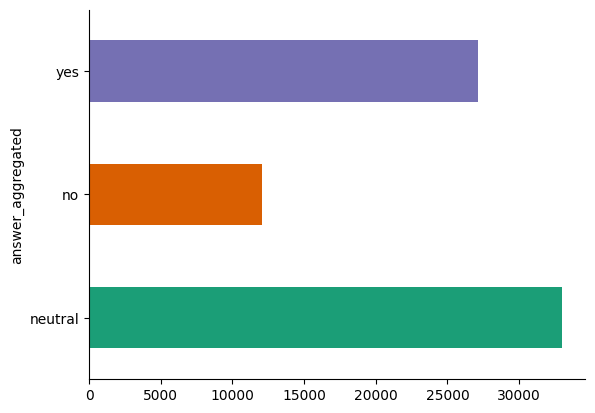

In [18]:
# @title answer_aggregated

from matplotlib import pyplot as plt
import seaborn as sns
df_filtered.groupby('answer_aggregated').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [19]:
import os
import torch
# from transformers import (
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     # BitsAndBytesConfig,
#     pipeline
# )

from langchain.text_splitter import CharacterTextSplitter
from langchain.document_transformers import Html2TextTransformer
from langchain.document_loaders import AsyncChromiumLoader

from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.llms import HuggingFacePipeline
from langchain.chains import LLMChain

In [20]:
df_final_sampled = df_final.sample(250)

In [21]:
import os
import re
import requests
from google.colab import userdata
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

def format_response (response: str) -> str:
    entries = re.split(r" (?<=]), (?=\[)", response)
    return [entry.strip("[]") for entry in entries]

os.environ ["GROQ_API_KEY"] = "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"

In [22]:
mistral_llm = ChatGroq(temperature = 0.2,model_name="llama3-8b-8192")

In [23]:
alldata=" "
for index, row in df_final_sampled.iterrows():
  alldata = alldata + " " +  row['final']

In [24]:
from langchain.text_splitter import CharacterTextSplitter

def split_text_with_overlap(text, chunk_size=200, overlap=10):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk)
        start += (chunk_size - overlap)
    return chunks

# Example usage
  # Replace with your actual string
chunks = split_text_with_overlap(alldata, chunk_size=200, overlap=10)

# Printing the chunks
for i, chunk in enumerate(chunks):
    print(f"Chunk {i+1}:\n{chunk}\n")

Chunk 1:
  eSamcore Kindle Fire 7 (2017) Case comes with a HD clear built-in screen protector Please note to peel off the protective film on both sides of the built-in screen protector before using. Full Body 

Chunk 2:
Full Body Protective Design with Dual-Layer Rugged Impact Resistance Materials It’s a fire7 kickstand case combined with hard shell inner, flexible rugged rubberized TPU exterior.  With built-in scree

Chunk 3:
t-in screen protector, 3 layers combination provides water resistance, dirt and shock protection for your device.  Easy Access to All Features Easy access to all buttons, camera, speaker and ports. Th

Chunk 4:
 ports. The port covers prevent dust from memory card port, headphone jack and charging port.  360 Degree Rotating Leather Hand Strap Aids teachers, readers, trade show vendors, and CEO business leade

Chunk 5:
ness leaders during presentations using our smart adjustable leather hand strap design.  Hands-free Media Viewing with Integrated Kickstand Allows 

In [25]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import faiss

In [26]:
class HuggingFaceEmbeddings:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def encode(self, texts):
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

# Instantiate the embeddings model
model_name = 'sentence-transformers/all-mpnet-base-v2'
hf_embeddings = HuggingFaceEmbeddings(model_name)

# Encode chunked documents
embeddings = hf_embeddings.encode([chunk for chunk in chunks])

# Create FAISS index
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(embeddings)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [27]:
from langchain.docstore.document import Document

In [28]:
class HuggingFaceEmbeddings:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def encode(self, texts):
        inputs = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).numpy()

    def embed_documents(self, documents):
        texts = [doc for doc in documents]
        return self.encode(texts)

    def embed_query(self, query):
        inputs = self.tokenizer(query, return_tensors='pt')
        outputs = self.model(**inputs)
        return outputs.last_hidden_state.mean(dim=1).detach().numpy()




In [29]:
model_name = 'sentence-transformers/all-mpnet-base-v2'
hf_embeddings = HuggingFaceEmbeddings(model_name)

In [30]:
def retrieve(query, k=5):
    query_embedding = hf_embeddings.encode([query])
    distances, indices = index.search(query_embedding, 5)
    return [chunks[i] for i in indices[0]]

# Example retrieval
query = "How much is the battery life of laptop"
retrieved_docs = retrieve(query)
for doc in retrieved_docs:
    print(doc)
documents = [Document(page_content=chunk) for chunk in retrieved_docs]

db = FAISS.from_documents(documents, hf_embeddings)
retriever = db.as_retriever()

shiba Satellite S55T-B5260 15.6-Inch Touchscreen LaptopIntel Core i7-4710HQ Processor (6M Cache, up to 3.5 GHz) with Intel Turbo Boost Technology 2.012 GB DIMM RAM1 TB 5400 rpm Hard Drive15.6-Inch Scr
e: Up to 16 Hours 30 min (2G) / Up to 17 Hours 30 min (3G), Standby: Up to 790 Hours (2G) / Up to 900 Hours (3G)LG G2 D802 4G LTE 32GB Unlocked GSM Quad-Core Android Smartphone - Black2G: GSM 850 / 90
  1366 768 HD display and powerful Quad Core Intel Atom x5-Z8350 (1.44GHz) with Intel HD Graphics (Gen7) ULTRA LIGHT BRILLIANTLY DURABLE- Your new laptop is so light and easy to carry around it even s
"AMAZING POWER: This laptop is backed with Intel Atom x5-Z8350 processor which can cope with high end tasks, games and applications. On board WIFI and Bluetooth 4.0 enables easy data transfer.AMPLE ST
M, 256GB Solid State Drive, Windows 8.1), BlackDisplay: 15.6  Ultra HD Touchscreen Display (3840 x 2160), 10-finger multi-touch support"CPU:  Intel i7-4700HQ (Haswell) 2.4GHz with Turbo Boost Tech

In [31]:
def retrieve_chunks(query, index, hf_embeddings, documents, top_k=5):
    # Embed the query
    query_embedding = hf_embeddings.embed_query(query)

    # Search FAISS index
    distances, indices = index.search(query_embedding, top_k)

    # Check the lengths of indices and documents
    num_documents = len(documents)
    retrieved_chunks = []
    for idx in indices[0]:
        if idx < num_documents:
            retrieved_chunks.append(documents[idx].page_content)
        else:
            print(f"Index {idx} is out of bounds for documents list of length {num_documents}")

    return retrieved_chunks

# Example query
query = "what is the battery life of laptop"
retrieved_chunks = retrieve_chunks(query, index, hf_embeddings, documents)

# Print retrieved chunks
for i, chunk in enumerate(retrieved_chunks):
    print(f"Chunk {i+1}: {chunk}")



Index 765 is out of bounds for documents list of length 5
Index 200 is out of bounds for documents list of length 5
Index 1182 is out of bounds for documents list of length 5
Index 628 is out of bounds for documents list of length 5
Index 1258 is out of bounds for documents list of length 5


In [32]:
retriever = db.as_retriever()

In [33]:
from langchain import PromptTemplate, LLMChain
from langchain_core.runnables import RunnablePassthrough
# Define the prompt template
prompt_template = """
note while returning final answer please print little bit of context from docs that you have used to generate answer
### [INST] Instruction: Answer the question based on your docs knowledge. Here is context to help:

{context}

### QUESTION:
{question} [/INST]
"""

# Create prompt from prompt template
prompt = PromptTemplate(
    input_variables=["context", "question"],
    template=prompt_template,
)

# Assume mistral_llm is defined elsewhere, and it's the language model you are using
# Create llm chain
llm_chain = LLMChain(llm=mistral_llm, prompt=prompt)

# Define a retriever function that retrieves context given a query
def retriever(query):
    # Example implementation using the previously defined retrieve_chunks function
    # Ensure index, hf_embeddings, and documents are properly defined
    return retrieve_chunks(query, index, hf_embeddings, documents)

# Create RAG chain
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | llm_chain
)

# Invoke the RAG chain
result = rag_chain.invoke("What is the best laptop")

# Print the result
print(result)


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use RunnableSequence, e.g., `prompt | llm` instead.
  warn_deprecated(


Index 241 is out of bounds for documents list of length 5
Index 200 is out of bounds for documents list of length 5
Index 240 is out of bounds for documents list of length 5
Index 250 is out of bounds for documents list of length 5
Index 246 is out of bounds for documents list of length 5
{'context': [], 'question': 'What is the best laptop', 'text': 'Based on my documentation knowledge, the "best" laptop is subjective and depends on various factors such as budget, usage, and personal preferences. However, here are some top-rated laptops across different categories:\n\n**For general use:**\n\n* Dell XPS 13: A popular choice for its sleek design, long battery life, and powerful performance. (Source: CNET)\n* Apple MacBook Air: A great option for those invested in the Apple ecosystem, offering a seamless user experience and impressive battery life. (Source: The Verge)\n\n**For gaming:**\n\n* Razer Blade 15: A top-notch gaming laptop with a powerful NVIDIA GeForce GPU, fast processor, and

In [34]:
result['context']

[]

In [35]:
text = result['text']

# Add line breaks to format the text as a paragraph
formatted_text = text.replace('\n', ' ')  # Replace existing line breaks with spaces
formatted_text = formatted_text.replace('. ', '.\n\n')  # Add double line breaks after periods

# Print the formatted text
print(formatted_text)

Based on my documentation knowledge, the "best" laptop is subjective and depends on various factors such as budget, usage, and personal preferences.

However, here are some top-rated laptops across different categories:  **For general use:**  * Dell XPS 13: A popular choice for its sleek design, long battery life, and powerful performance.

(Source: CNET) * Apple MacBook Air: A great option for those invested in the Apple ecosystem, offering a seamless user experience and impressive battery life.

(Source: The Verge)  **For gaming:**  * Razer Blade 15: A top-notch gaming laptop with a powerful NVIDIA GeForce GPU, fast processor, and customizable backlighting.

(Source: PCMag) * MSI GS65 Stealth: A slim and lightweight gaming laptop with a powerful Intel Core i9 processor and NVIDIA GeForce GTX 1070 graphics.

(Source: Laptop Mag)  **For budget-conscious buyers:**  * Acer Aspire 3: A budget-friendly laptop with a decent processor, ample storage, and a long-lasting battery.

(Source: Tec